# SI221 - TP PCA & K-means

### Données

Nous allons travailler sur des images satellitaire: celles-ci sont capturées via différent capteurs, chacun correspondant à un domaine de longueur d'ondes. Nous avons donc, pour chaque image, un certain nombre de *canaux* - chacun correspondant à un *domaine spectral*. 

- Données SPOT sur Tarascon: La taille du pixel est de 20m. Il y a 3 canaux: 
    - 0.50-0.59 $\mu$
    - 0.61-0.68 $\mu$
    - 0.78-0.89 $\mu$
    
- Données LANDSAT sur Tarascon: La taille du pixel est de 30m. Il y a 8 canaux:
    - 0.45-0.52 $\mu$       
    - 0.52-0.60 $\mu$     
    - 0.63-0.69 $\mu$
    - 0.75-0.90 $\mu$ (Proche InfraRouge : PIR)     
    - 2.08-2.35 $\mu$ (Moyen InfraRouge : MIR)    
    - 10.40-12.50 $\mu$ (infra rouge thermique)      
    - 1.55-1.75 $\mu$ (Moyen InfraRouge : MIR)     
    - 0.52-0.90 $\mu$ (panchromatique)   
    
- Données LANDSAT sur Kedougou: La taille du pixel est de 30m; mais, à la différence des données acquises sur Tarascon, il y a un problème d’acquisition de données inhérent au capteur. Il y a ici 6 canaux:
    - 0.45-0.52 $\mu$
    - 0.52-0.60 $\mu$
    - 0.63-0.69 $\mu$
    - 0.76-0.90 $\mu$
    - 2.08-2.35 $\mu$
    - 1.55-1.75 $\mu$

### PCA

Le recours à l’ACP va permettre de réduire la dimension de l’espace de représentation et ici de réduire le nombre de canaux nécessaires pour conserver l’essentiel de l’information. De manière générale, le but de l’ACP est de visualiser dans un espace de plus petite dimension les proximités entre les observations (ici les pixels) et ainsi les corrélation entre les variables (les valeurs des pixels sur les différents canaux).  

**Rappel sur l'ACP**: Avec $N$ individus, pour lesquels on dispose de $p$ caractéristiques (ce qui veut dire que son vecteur est de dimension $p$), on notera $\mathbf{x}^i_k$ la $k$ième caractéristique de l'individu $i$. On note donc $\mathbf{X}$ la matrice dans laquelle chaque ligne est constituée par un individu et chaque colonne représente une variable. 

L'ACP est constituée par les étapes suivantes :
- Centrage et réduction des données: Notant $m_k$ et $\sigma_k$, les moyennes et écarts-type de la $k$ième variable, on notera $\mathbf{x}'^i_k=\frac{\mathbf{x}^i_k-m_k}{\sigma_k}$ la donnée centrée réduite.
- Calcul de la matrice de covariance des données centrées réduites.
- Calcul des valeurs propres $\lambda_j$ et vecteurs propres $\mathbf{u}_j$ de la matrice de covariance;
- Vérification de l'ordre des vecteurs propres selon les valeurs propres croissantes;
- Calcul des composantes principales $\mathbf{x}''^i_q$ exprimées dans la base des vecteurs propres: $$ \mathbf{x}''^i_q={\mathbf{x}'^i}^T \mathbf{u}_q $$


On obtient donc de nouvelles variables constituées par des combinaisons linéaires des anciennes. Les composantes principales contiennent une quantité d'information proportionnelle à la valeur propre correspondante. On définit ainsi le pourcentage d'inertie par $\frac{\lambda_i}{\sum_{j=1}^{p}\lambda_j}$. 

Le but premier de ce TP est **l'application du PCA (ou ACP, Analyse en composantes principales) à ces images satellitaires, ou les individus sont chaque canal de l'image, et les variables chacun des pixels**. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Les données proviennent de fichier .mat, avec un fichier par canal. On peut commencer par travailler avec SPOT, qui n'a que 3 canaux. Commençons par charger les images et les réunir sur une même matrice.

In [2]:
from scipy.io import loadmat

def load_image(path_img):
    im_loaded = loadmat('./'+ path_img +'.mat')
    return im_loaded['imm']

In [3]:
# First image: SPOT
path_img = 'SPOT/cam'
n_bands = 3

# Let's take a look at the first channel's size
img = load_image(path_img +'1')
print(img.shape)

(512, 512)


In [4]:
img = np.zeros((img.shape[0], img.shape[1], n_bands))
print(img.shape)

# Stacking up images into the numpy array:
img1 = load_image(path_img +'1')
img2 = load_image(path_img +'2')
img3 = load_image(path_img +'3')

img[:,:,0] = img1
img[:,:,1] = img2
img[:,:,2] = img3

(512, 512, 3)


Essayons d'abord de comprendre, en regardant les images, les caractéristiques des différents canaux et les informations qu'ils comportent. 

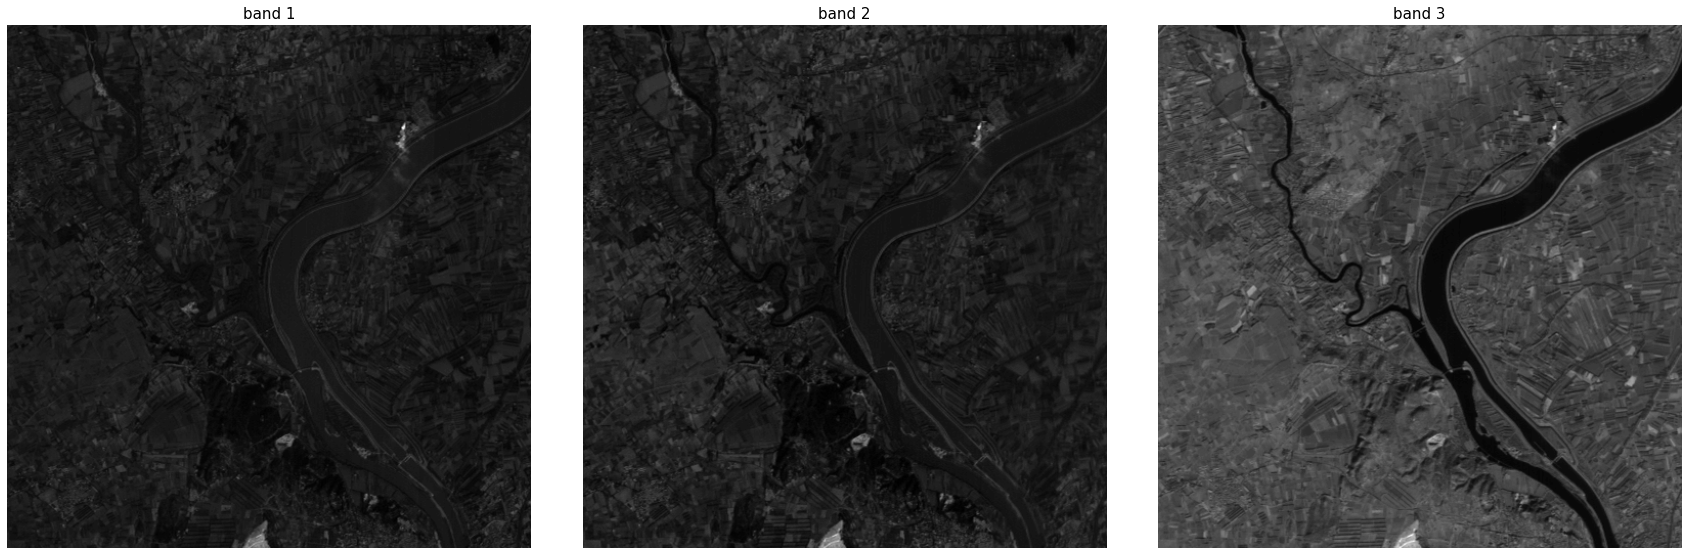

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

fig,axes = plt.subplots(1,n_bands, figsize=(n_bands*10,12), sharex='all', sharey='all')
fig.subplots_adjust(wspace=0.1, hspace=0.15)
axes = axes.ravel()

for i in range(n_bands):
    # Use floats instead of 8-bit integers for a clearer view of the image
    axes[i].imshow(img[:,:,i] / 255, cmap='gray')
    axes[i].set_title('band '+str(i+1),fontsize=15)
    axes[i].axis('off')

Qu'observez-vous ? 

Chaque image est un individu: on va d'abord redimensionner les images en vecteurs (pas besoin d'information de structure spatiale !) et on calcule la moyenne et l’écart-type de chacun de ces vecteurs pour les centrer.

In [6]:
# Reshape the image for practicality: 
img1_reshaped = img1.reshape(1,512*512)
img2_reshaped = img2.reshape(1,512*512)
img3_reshaped = img3.reshape(1,512*512)
print(img1_reshaped)

[[29 30 32 ... 39 35 26]]


In [7]:
# Standardization:
channel1 = ((img1_reshaped - np.mean(img1_reshaped)) / np.cov(img1_reshaped) )
channel2 = ((img2_reshaped - np.mean(img2_reshaped)) / np.cov(img2_reshaped) )
channel3 = ((img3_reshaped - np.mean(img3_reshaped)) / np.cov(img3_reshaped) )

**Vecteurs propres et valeurs propres**: on concatène les vecteurs centrés en une seule matrice dont on calcule la matrice de covariance, qui mesure la relation entre les images. On calcule ensuite les valeurs propres et les vecteurs propres de la matrice de covariance grâce à la fonction ```eig```. On obtient les vecteurs propres, concaténés. 

In [8]:
X = np.concatenate((channel1,channel2,channel3))
# Compte the covariance matrix:
X_cov = np.cov(X)

# Compute eigenvalues and vectors with eig:
X_eigenvalues, X_eigenvectors = np.linalg.eig(X_cov)

# Check that that it worked using the formula:
print(X_eigenvalues)
print('oui')
print(np.sort(X_eigenvalues))
print('oui')
print(X_cov)
print(X_eigenvectors @ np.diag([i for i in X_eigenvalues]) @ np.linalg.inv(X_eigenvectors) )


[0.1258598  0.00463343 0.0160435 ]
oui
[0.00463343 0.0160435  0.1258598 ]
oui
[[0.07623022 0.05573159 0.01800207]
 [0.05573159 0.04890003 0.01730442]
 [0.01800207 0.01730442 0.02140648]]
[[0.07623022 0.05573159 0.01800207]
 [0.05573159 0.04890003 0.01730442]
 [0.01800207 0.01730442 0.02140648]]


In [9]:
# Lets sort the eigenvalues to be able to choose the components by importance:

sorted_eigenvalues = np.sort(X_eigenvalues)

sorted_eigenvectors = X_eigenvectors.copy()
sorted_eigenvectors[0] = X_eigenvectors[1]
sorted_eigenvectors[1] = X_eigenvectors[2]
sorted_eigenvectors[2] = X_eigenvectors[0]

print(sorted_eigenvalues)
print(sorted_eigenvectors.shape)
print(X.shape)

[0.00463343 0.0160435  0.1258598 ]
(3, 3)
(3, 262144)


**Calcul des composantes principales**: On multiplie la matrice concaténée par la matrice des vecteurs propres pour obtenir les composantes principales dans la base des vecteurs propres; ainsi, on va pouvoir trouver le sous-espace optimal pour visualiser les proximités entre les observations, et les corrélations entre les variables. 

(262144, 3)


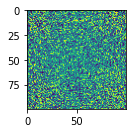

In [10]:
# Lets get the components in separate matrices, so we can display them easily:
X_new_base = X.T @ sorted_eigenvectors
print(X_new_base.shape)
img1_new_base = X_new_base[:,0]
img2_new_base = X_new_base[:,1]
img3_new_base = X_new_base[:,2]

img1_new_base_reshaped = img1_new_base.reshape(512,512)
img2_new_base_reshaped = img2_new_base.reshape(512,512)
img3_new_base_reshaped = img3_new_base.reshape(512,512)

plt.subplot(211)
plt.imshow(np.random.random((100, 100)))

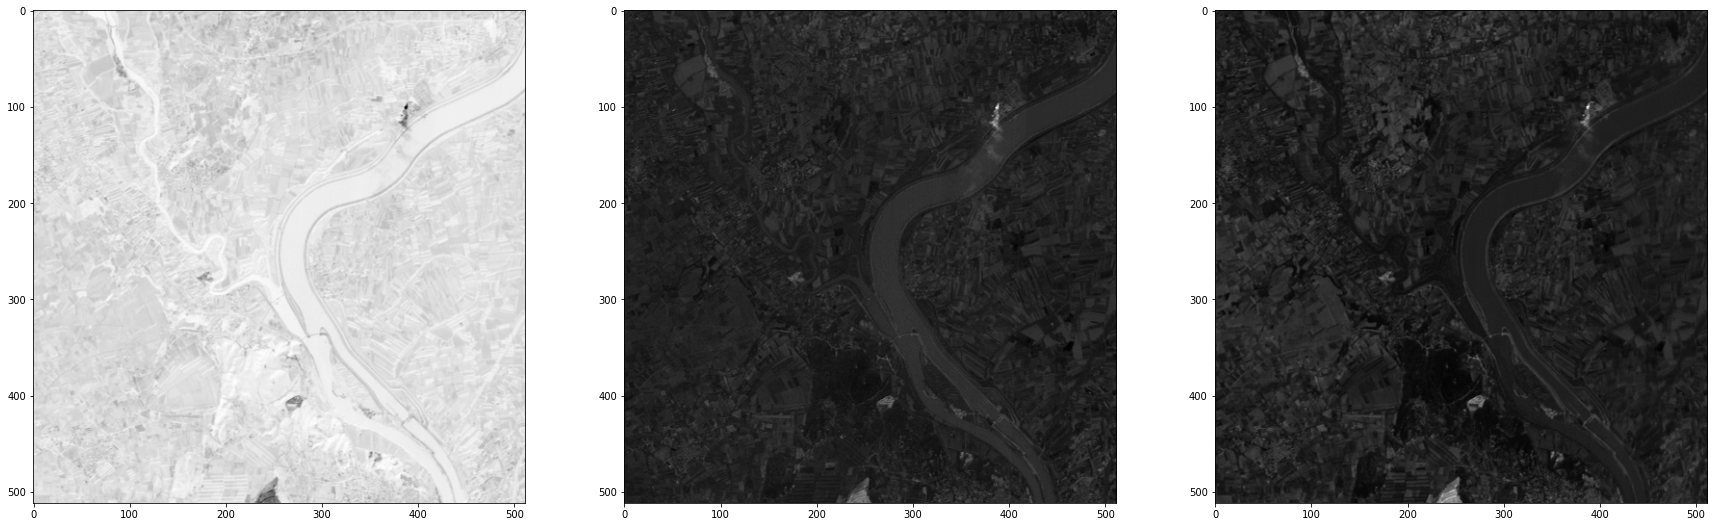

In [11]:
plt.figure(figsize=(n_bands*10, 12))

# Visualize them with imshow: 


plt.subplot(1,n_bands,0+1)

plt.imshow(img1_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,1+1)
plt.imshow(img2_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,2+1)
plt.imshow(img3_new_base_reshaped, cmap='gray')

*Visuellement, on constate que la première composante détecte un certain nombre d'emplacements précis, ainsi que des limites - la seconde semble détecter l'eau et les champs, et la dernière indique des artefacts verticaux sans doute liés aux capteurs*.

In [12]:
# Compute the percentage of inertia of each component:
pourcentage_inertie1 = sorted_eigenvalues[0]/np.sum(sorted_eigenvalues)
pourcentage_inertie2 = sorted_eigenvalues[1]/np.sum(sorted_eigenvalues)
pourcentage_inertie3 = sorted_eigenvalues[2]/np.sum(sorted_eigenvalues)

print(pourcentage_inertie1)
print(pourcentage_inertie2)
print(pourcentage_inertie3)

0.03161958173818481
0.10948447522392632
0.8588959430378889


**ACP sur les données LANDSAT sur Tarascon**: Effectuez l’analyse en composantes principales sur les données LANDSAT sur Tarascon. Affichez les images résultats. Calculez le pourcentage d’inertie associé à chaque image et interprétez qualitativement les résultats. Combien d’images faut-il garder pour conserver au moins 95% de l’information ?

In [13]:
path_img = 'Landstat_Tarascon/landsattarasconC'
n_bands = 8
img = load_image(path_img +'1')
print(img.shape)

img = np.zeros((img.shape[0], img.shape[1], n_bands))
print(img.shape)

img1 = load_image(path_img +'1')
img2 = load_image(path_img +'2')
img3 = load_image(path_img +'3')
img4 = load_image(path_img +'4')
img5 = load_image(path_img +'5')
img6 = load_image(path_img +'6')
img7 = load_image(path_img +'7')
img8 = load_image(path_img +'8')

img1_reshaped = img1.reshape(1,512*512)
img2_reshaped = img2.reshape(1,512*512)
img3_reshaped = img3.reshape(1,512*512)
img4_reshaped = img4.reshape(1,512*512)
img5_reshaped = img5.reshape(1,512*512)
img6_reshaped = img6.reshape(1,512*512)
img7_reshaped = img7.reshape(1,512*512)
img8_reshaped = img8.reshape(1,512*512)


channel1 = ((img1_reshaped - np.mean(img1_reshaped)) / np.cov(img1_reshaped) )
channel2 = ((img2_reshaped - np.mean(img2_reshaped)) / np.cov(img2_reshaped) )
channel3 = ((img3_reshaped - np.mean(img3_reshaped)) / np.cov(img3_reshaped) )
channel4 = ((img4_reshaped - np.mean(img4_reshaped)) / np.cov(img4_reshaped) )
channel5 = ((img5_reshaped - np.mean(img5_reshaped)) / np.cov(img5_reshaped) )
channel6 = ((img6_reshaped - np.mean(img6_reshaped)) / np.cov(img6_reshaped) )
channel7 = ((img7_reshaped - np.mean(img7_reshaped)) / np.cov(img7_reshaped) )
channel8 = ((img8_reshaped - np.mean(img8_reshaped)) / np.cov(img8_reshaped) )

X = np.concatenate((channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8))
# Compte the covariance matrix:
X_cov = np.cov(X)

# Compute eigenvalues and vectors with eig:
X_eigenvalues, X_eigenvectors = np.linalg.eig(X_cov)

(512, 512)
(512, 512, 8)


In [14]:
sorted_eigenvalues = np.sort(X_eigenvalues)

sorted_eigenvectors = X_eigenvectors.copy()
print(X_eigenvalues)
print('oui')
print(sorted_eigenvalues)
sorted_eigenvectors[0] = X_eigenvectors[7]
sorted_eigenvectors[1] = X_eigenvectors[6]
sorted_eigenvectors[2] = X_eigenvectors[5]
sorted_eigenvectors[3] = X_eigenvectors[4]
sorted_eigenvectors[4] = X_eigenvectors[3]
sorted_eigenvectors[5] = X_eigenvectors[2]
sorted_eigenvectors[6] = X_eigenvectors[1]
sorted_eigenvectors[7] = X_eigenvectors[0]


[9.97299987e-03 3.21180200e-03 1.15586204e-03 3.68685061e-04
 2.42058646e-04 5.08453071e-05 1.66459313e-05 1.45537180e-05]
oui
[1.45537180e-05 1.66459313e-05 5.08453071e-05 2.42058646e-04
 3.68685061e-04 1.15586204e-03 3.21180200e-03 9.97299987e-03]


In [15]:
X_new_base = X.T @ sorted_eigenvectors
print(X_new_base.shape)
img1_new_base = X_new_base[:,0]
img2_new_base = X_new_base[:,1]
img3_new_base = X_new_base[:,2]
img4_new_base = X_new_base[:,3]
img5_new_base = X_new_base[:,4]
img6_new_base = X_new_base[:,5]
img7_new_base = X_new_base[:,6]
img8_new_base = X_new_base[:,7]

img1_new_base_reshaped = img1_new_base.reshape(512,512)
img2_new_base_reshaped = img2_new_base.reshape(512,512)
img3_new_base_reshaped = img3_new_base.reshape(512,512)
img4_new_base_reshaped = img4_new_base.reshape(512,512)
img5_new_base_reshaped = img5_new_base.reshape(512,512)
img6_new_base_reshaped = img6_new_base.reshape(512,512)
img7_new_base_reshaped = img7_new_base.reshape(512,512)
img8_new_base_reshaped = img8_new_base.reshape(512,512)

(262144, 8)


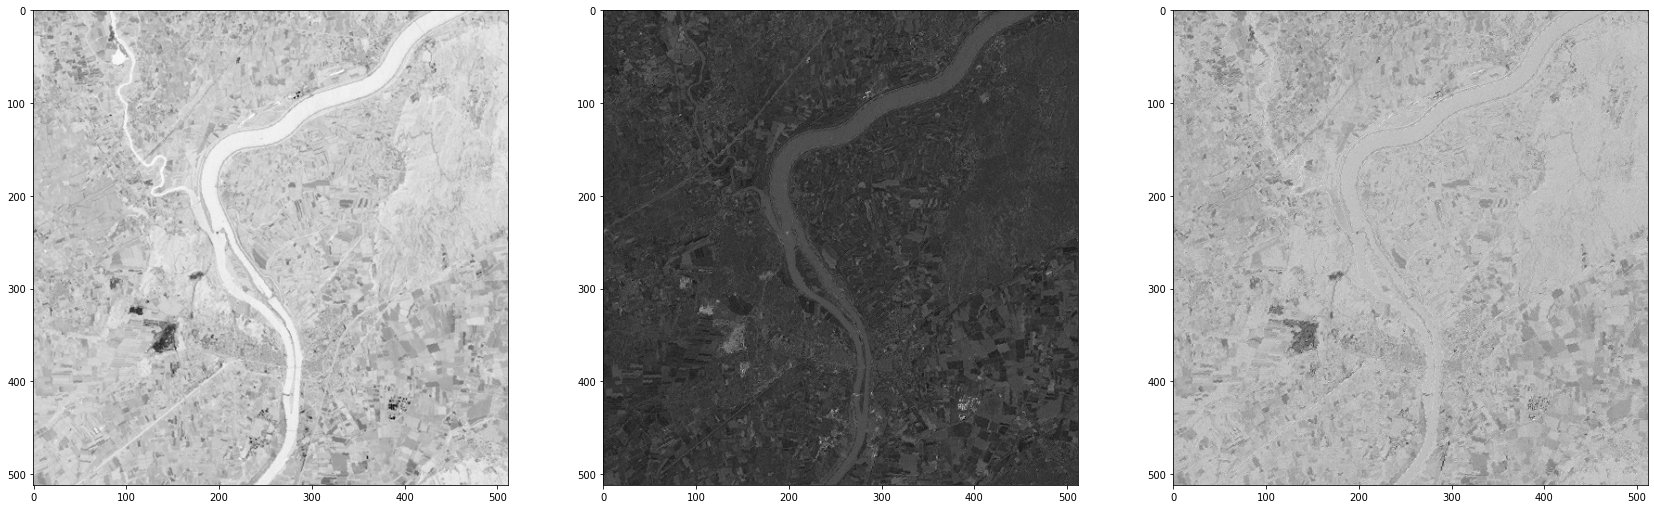

In [16]:
plt.figure(figsize=(n_bands*10, 12))

# Visualize them with imshow: 


plt.subplot(1,n_bands,0+1)
plt.imshow(img1_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,1+1)
plt.imshow(img2_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,2+1)
plt.imshow(img3_new_base_reshaped, cmap='gray')


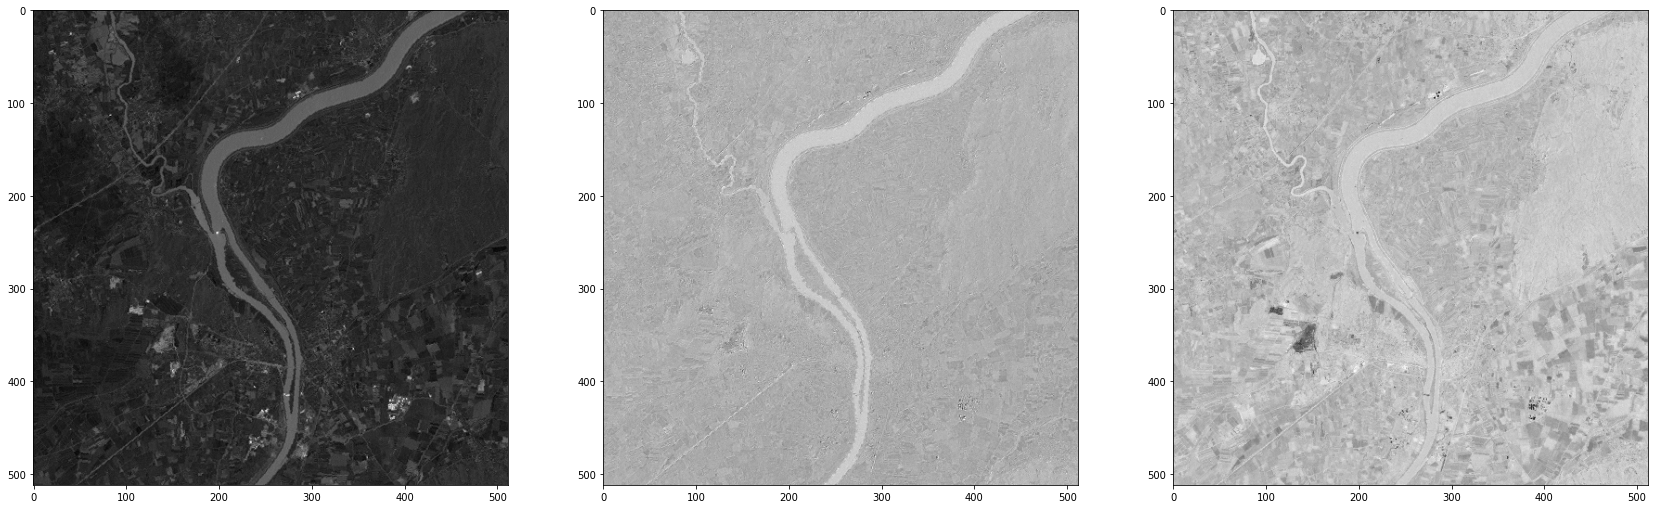

In [17]:
plt.figure(figsize=(n_bands*10, 12))

plt.subplot(1,n_bands,3+1)
plt.imshow(img4_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,4+1)
plt.imshow(img5_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,5+1)
plt.imshow(img6_new_base_reshaped, cmap='gray')


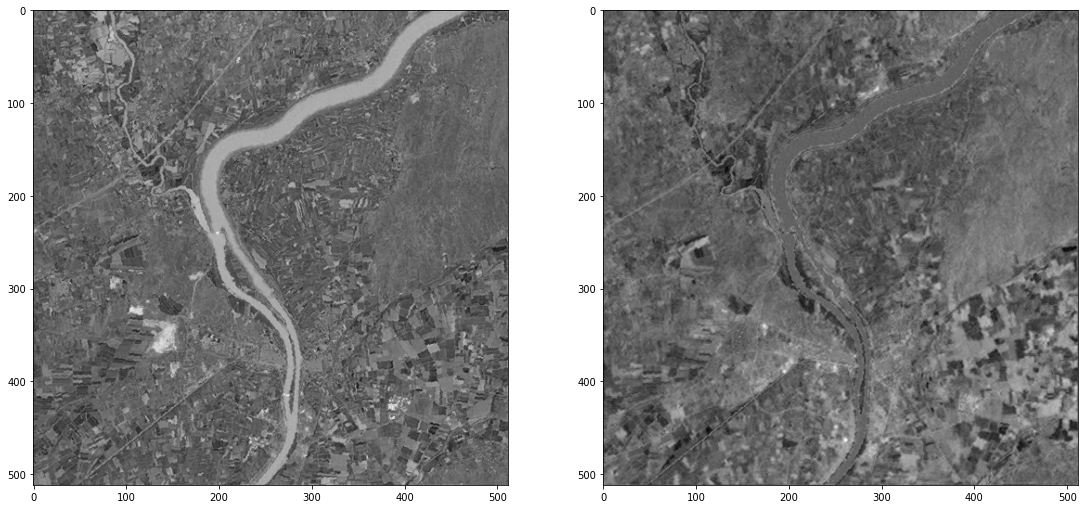

In [18]:
plt.figure(figsize=(n_bands*10, 12))

plt.subplot(1,n_bands,6+1)
plt.imshow(img7_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,7+1)
plt.imshow(img8_new_base_reshaped, cmap='gray')

In [19]:
# Compute the percentage of inertia of each component:
pourcentage_inertie1 = sorted_eigenvalues[0]/np.sum(sorted_eigenvalues)
pourcentage_inertie2 = sorted_eigenvalues[1]/np.sum(sorted_eigenvalues)
pourcentage_inertie3 = sorted_eigenvalues[2]/np.sum(sorted_eigenvalues)
pourcentage_inertie4 = sorted_eigenvalues[3]/np.sum(sorted_eigenvalues)
pourcentage_inertie5 = sorted_eigenvalues[4]/np.sum(sorted_eigenvalues)
pourcentage_inertie6 = sorted_eigenvalues[5]/np.sum(sorted_eigenvalues)
pourcentage_inertie7 = sorted_eigenvalues[6]/np.sum(sorted_eigenvalues)
pourcentage_inertie8 = sorted_eigenvalues[7]/np.sum(sorted_eigenvalues)

print(pourcentage_inertie1)
print(pourcentage_inertie2)
print(pourcentage_inertie3)
print(pourcentage_inertie4)
print(pourcentage_inertie5)
print(pourcentage_inertie6)
print(pourcentage_inertie7)
print(pourcentage_inertie8)


0.0009680888645931067
0.001107259371991669
0.0033821443774547694
0.016101334347946892
0.024524310629900885
0.07688600024696393
0.21364367144529714
0.6633871907158516


In [20]:
inertie = [pourcentage_inertie1,pourcentage_inertie2,pourcentage_inertie3,pourcentage_inertie4,pourcentage_inertie5,pourcentage_inertie6,pourcentage_inertie7,pourcentage_inertie8] 

s = 0
truc = 4
for i in range(1,truc):
    s+=inertie[-i]
print(s)


0.9539168624081127


On constate qu'il faut prendre au moins 4 images pour avoir 95% d'information

**ACP sur les données LANDSAT sur Kedougou**: Effectuez une ACP sur ce jeu de données. Comparez le résultat avec le dernier capteur défectueux (```CANAL6bruit```) et l'original.

In [21]:
# Capteur normal:
path_img = 'Landstat_Kedougou/landsatKedougouC'
n_bands = 6
img = load_image(path_img +'1')
print(img.shape)

img = np.zeros((img.shape[0], img.shape[1], n_bands))
print(img.shape)

img1 = load_image(path_img +'1')
img2 = load_image(path_img +'2')
img3 = load_image(path_img +'3')
img4 = load_image(path_img +'4')
img5 = load_image(path_img +'5')
img6 = load_image(path_img +'6')

img1_reshaped = img1.reshape(1,256*256)
img2_reshaped = img2.reshape(1,256*256)
img3_reshaped = img3.reshape(1,256*256)
img4_reshaped = img4.reshape(1,256*256)
img5_reshaped = img5.reshape(1,256*256)
img6_reshaped = img6.reshape(1,256*256)



channel1 = ((img1_reshaped - np.mean(img1_reshaped)) / np.cov(img1_reshaped) )
channel2 = ((img2_reshaped - np.mean(img2_reshaped)) / np.cov(img2_reshaped) )
channel3 = ((img3_reshaped - np.mean(img3_reshaped)) / np.cov(img3_reshaped) )
channel4 = ((img4_reshaped - np.mean(img4_reshaped)) / np.cov(img4_reshaped) )
channel5 = ((img5_reshaped - np.mean(img5_reshaped)) / np.cov(img5_reshaped) )
channel6 = ((img6_reshaped - np.mean(img6_reshaped)) / np.cov(img6_reshaped) )


X = np.concatenate((channel1,channel2,channel3,channel4,channel5,channel6))
# Compte the covariance matrix:
X_cov = np.cov(X)

# Compute eigenvalues and vectors with eig:
X_eigenvalues, X_eigenvectors = np.linalg.eig(X_cov)
# A compléter

(256, 256)
(256, 256, 6)


In [22]:
sorted_eigenvalues = np.sort(X_eigenvalues)

sorted_eigenvectors = X_eigenvectors.copy()
print(X_eigenvalues)
print('oui')
print(sorted_eigenvalues)
sorted_eigenvectors[0] = X_eigenvectors[5]
sorted_eigenvectors[1] = X_eigenvectors[4]
sorted_eigenvectors[2] = X_eigenvectors[3]
sorted_eigenvectors[3] = X_eigenvectors[2]
sorted_eigenvectors[4] = X_eigenvectors[1]
sorted_eigenvectors[5] = X_eigenvectors[0]


[0.09755125 0.00641491 0.00210212 0.00180069 0.000524   0.0002542 ]
oui
[0.0002542  0.000524   0.00180069 0.00210212 0.00641491 0.09755125]


In [23]:
X_new_base = X.T @ sorted_eigenvectors
print(X_new_base.shape)
img1_new_base = X_new_base[:,0]
img2_new_base = X_new_base[:,1]
img3_new_base = X_new_base[:,2]
img4_new_base = X_new_base[:,3]
img5_new_base = X_new_base[:,4]
img6_new_base = X_new_base[:,5]


img1_new_base_reshaped = img1_new_base.reshape(256,256)
img2_new_base_reshaped = img2_new_base.reshape(256,256)
img3_new_base_reshaped = img3_new_base.reshape(256,256)
img4_new_base_reshaped = img4_new_base.reshape(256,256)
img5_new_base_reshaped = img5_new_base.reshape(256,256)
img6_new_base_reshaped = img6_new_base.reshape(256,256)


(65536, 6)


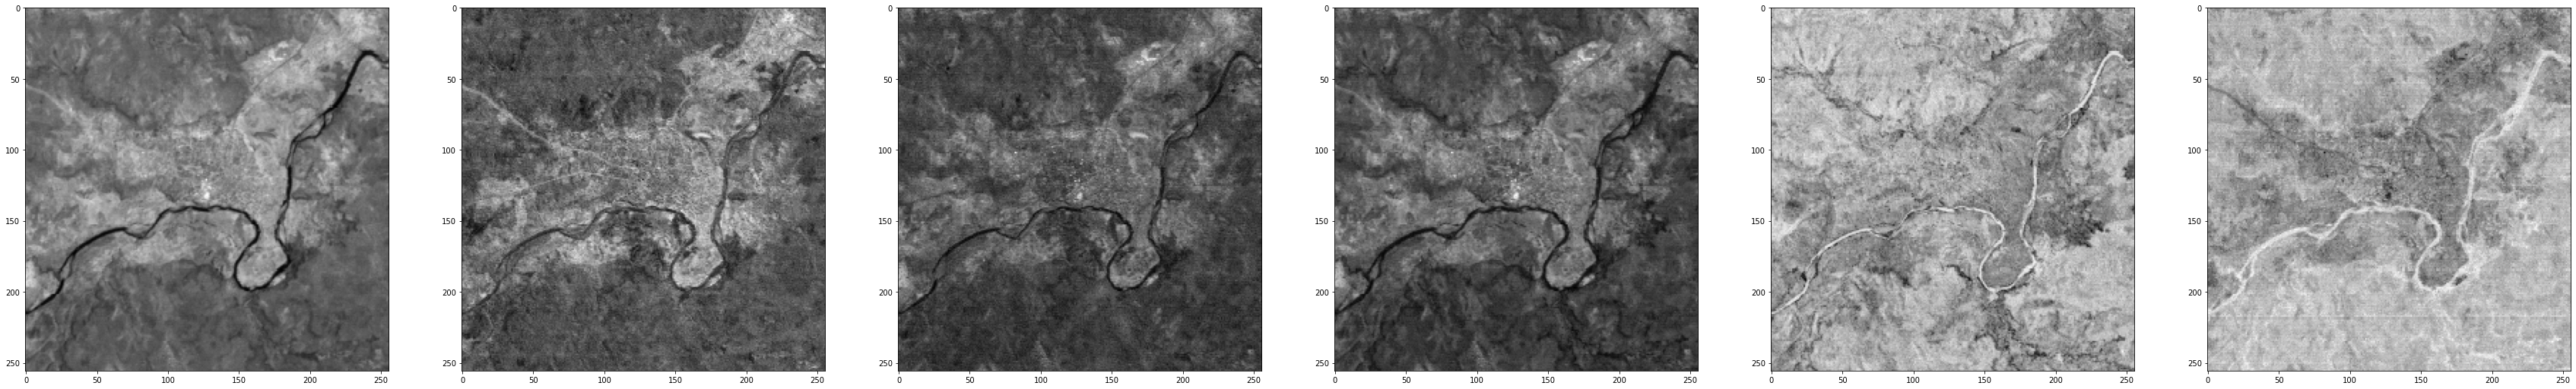

In [24]:
plt.figure(figsize=(n_bands*10, 12))

# Visualize them with imshow: 


plt.subplot(1,n_bands,0+1)
plt.imshow(img1_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,1+1)
plt.imshow(img2_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,2+1)
plt.imshow(img3_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,3+1)
plt.imshow(img4_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,4+1)
plt.imshow(img5_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,5+1)
plt.imshow(img6_new_base_reshaped, cmap='gray')

In [25]:
pourcentage_inertie1 = sorted_eigenvalues[0]/np.sum(sorted_eigenvalues)
pourcentage_inertie2 = sorted_eigenvalues[1]/np.sum(sorted_eigenvalues)
pourcentage_inertie3 = sorted_eigenvalues[2]/np.sum(sorted_eigenvalues)
pourcentage_inertie4 = sorted_eigenvalues[3]/np.sum(sorted_eigenvalues)
pourcentage_inertie5 = sorted_eigenvalues[4]/np.sum(sorted_eigenvalues)
pourcentage_inertie6 = sorted_eigenvalues[5]/np.sum(sorted_eigenvalues)


print(pourcentage_inertie1)
print(pourcentage_inertie2)
print(pourcentage_inertie3)
print(pourcentage_inertie4)
print(pourcentage_inertie5)
print(pourcentage_inertie6)


0.0023396578010200743
0.004822931349276008
0.016573771651172527
0.019348153428609297
0.05904347519929344
0.8978720105706287


In [26]:
# Avec le bruit: 
img_b = load_image('Landstat_Kedougou/landsatKedougouC6bruit')
imgb_reshaped = img_b.reshape(1,256*256)
channelb = ((imgb_reshaped - np.mean(imgb_reshaped)) / np.cov(imgb_reshaped) )

Xb = np.concatenate((channel1,channel2,channel3,channel4,channel5,channelb))
# Compte the covariance matrix:
Xb_cov = np.cov(Xb)

# Compute eigenvalues and vectors with eig:
Xb_eigenvalues, Xb_eigenvectors = np.linalg.eig(Xb_cov)

sorted_eigenvalues = np.sort(Xb_eigenvalues)

sorted_eigenvectors = Xb_eigenvectors.copy()
print(Xb_eigenvalues)
print('oui')
print(sorted_eigenvalues)
sorted_eigenvectors[0] = Xb_eigenvectors[4]
sorted_eigenvectors[1] = Xb_eigenvectors[5]
sorted_eigenvectors[2] = Xb_eigenvectors[3]
sorted_eigenvectors[3] = Xb_eigenvectors[2]
sorted_eigenvectors[4] = Xb_eigenvectors[1]
sorted_eigenvectors[5] = Xb_eigenvectors[0]



[0.09395271 0.00623647 0.00311647 0.00197724 0.00037276 0.00087345]
oui
[0.00037276 0.00087345 0.00197724 0.00311647 0.00623647 0.09395271]


(65536, 6)


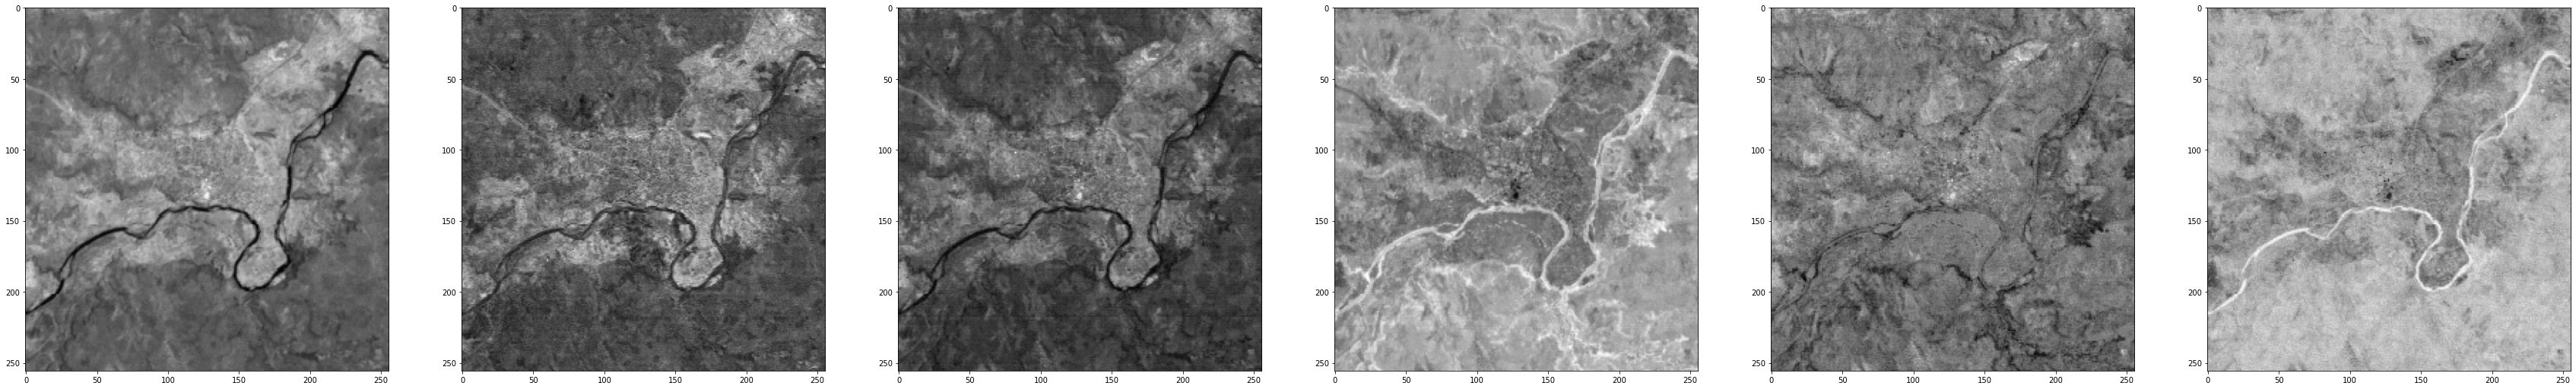

In [27]:
Xb_new_base = X.T @ sorted_eigenvectors
print(Xb_new_base.shape)
img1_new_base = Xb_new_base[:,0]
img2_new_base = Xb_new_base[:,1]
img3_new_base = Xb_new_base[:,2]
img4_new_base = Xb_new_base[:,3]
img5_new_base = Xb_new_base[:,4]
imgb_new_base = Xb_new_base[:,5]


img1_new_base_reshaped = img1_new_base.reshape(256,256)
img2_new_base_reshaped = img2_new_base.reshape(256,256)
img3_new_base_reshaped = img3_new_base.reshape(256,256)
img4_new_base_reshaped = img4_new_base.reshape(256,256)
img5_new_base_reshaped = img5_new_base.reshape(256,256)
imgb_new_base_reshaped = imgb_new_base.reshape(256,256)

plt.figure(figsize=(n_bands*10, 12))

# Visualize them with imshow: 


plt.subplot(1,n_bands,0+1)
plt.imshow(img1_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,1+1)
plt.imshow(img2_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,2+1)
plt.imshow(img3_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,3+1)
plt.imshow(img4_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,4+1)
plt.imshow(img5_new_base_reshaped, cmap='gray')
plt.subplot(1,n_bands,5+1)
plt.imshow(imgb_new_base_reshaped, cmap='gray')

In [28]:
pourcentage_inertie1 = sorted_eigenvalues[0]/np.sum(sorted_eigenvalues)
pourcentage_inertie2 = sorted_eigenvalues[1]/np.sum(sorted_eigenvalues)
pourcentage_inertie3 = sorted_eigenvalues[2]/np.sum(sorted_eigenvalues)
pourcentage_inertie4 = sorted_eigenvalues[3]/np.sum(sorted_eigenvalues)
pourcentage_inertie5 = sorted_eigenvalues[4]/np.sum(sorted_eigenvalues)
pourcentage_inertieb = sorted_eigenvalues[5]/np.sum(sorted_eigenvalues)


print(pourcentage_inertie1)
print(pourcentage_inertie2)
print(pourcentage_inertie3)
print(pourcentage_inertie4)
print(pourcentage_inertie5)
print(pourcentage_inertieb)

0.0034991765813962693
0.0081991579462825
0.01856053229928024
0.029254618069917752
0.05854236541773577
0.8819441496853874


*L’effet lié au capteur n’est pas négligeable si on ne regarde que la première image puisqu’il y a 8% de différence entre les deux. Cependant, si on considère plusieurs images, son impact est limité (si on considère 3 images, il n’y a que 2.2% de différence : il faut donc toujours utiliser au moins 3 images pour conserver 90% de l’information).*

### K-means

Dans cette partie, on souhaite réaliser un classificateur automatique pour réaliser une segmentation simple d'images : par exemple, pour séparer terres et rivière.
- Tracer l’histogramme canal par canal est instructif !
- La recherche de prototypes nécessite un peu de patience : il faut rechercher sur l’image les coordonnées de points dont on a pu (ou su) voir l’originalité.

**Classification rivière-terre**: Commencez par tester la procédure sur *SPOT* à l'aide des valeurs exemples pour l’eau et sur la terre. 

In [29]:
def histogramme(image):
    hist = np.zeros(256, dtype=np.float32)
    shap = image.shape
    for j in range(shap[0]):
        for i in range(shap[1]):
            valeur = image[j,i]
            hist[int(valeur)] += 1
    return hist

In [76]:
path_img = 'SPOT/cam' 
n_bands = 3 
size = 512 

img1 = load_image(path_img +'1')
img2 = load_image(path_img +'2')
img3 = load_image(path_img +'3')

hist1 = histogramme(img1)
hist2 = histogramme(img2)
hist3 = histogramme(img3)
print(img1)

[[29 30 32 ... 43 36 29]
 [35 37 38 ... 40 32 28]
 [32 35 34 ... 32 32 34]
 ...
 [31 32 32 ... 29 28 26]
 [32 33 33 ... 37 31 24]
 [33 34 33 ... 39 35 26]]


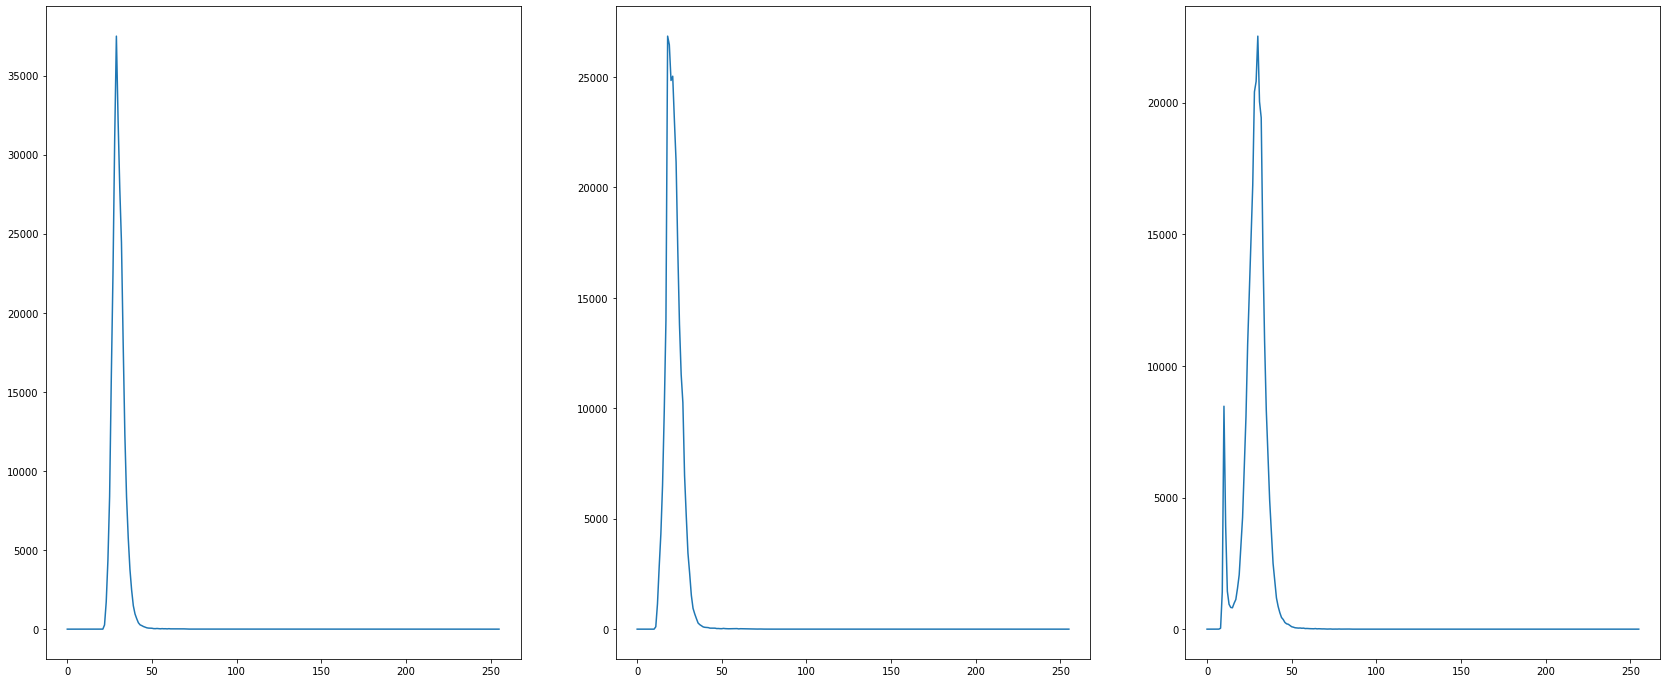

In [37]:
plt.figure(figsize=(n_bands*10, 12))

# Use the "histogramme" function to have an intuition of pixel repartition on each image

plt.subplot(1,n_bands,0+1)
plt.plot(hist1)
plt.subplot(1,n_bands,1+1)
plt.plot(hist2)
plt.subplot(1,n_bands,2+1)
plt.plot(hist3)

In [32]:
# Lieu du pixel caracteristique de l'eau
p1=[210, 150]
# Lieu du pixel caracteristique de la terre
p2=[50, 50]

In [33]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\documents\télécom\programmation\workspace python\venv\scripts\python.exe -m pip install --upgrade pip' command.


Utilisez la classe ```KMeans``` de ```sklearn```. Choississez le nombre de classes avec ```n_clusters``` et les centres initiaux des classes avec ```init```. Enfin, faites tourner l'algorithme sur l'image choisie avec ```.fit()``` et obtenez les classes de chaque pixel avec ```.predict()```. 
N'oubliez pas d'adapter la structure des données: nous n'avons ici qu'un exemple pour la procédure (un seul canal) avec un grand nombre de caractéristiques à classer (les pixels) - choississez les tailles de vos entrées en conséquence ! 

d:\documents\télécom\programmation\workspace python\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=2.
  super()._check_params_vs_input(X, default_n_init=10)


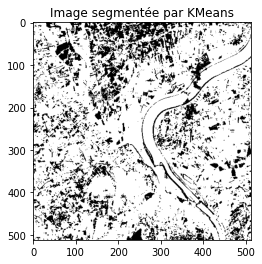

In [81]:
import sklearn
from sklearn.cluster import KMeans
n_class = 2
init = np.array([[210],[50]])

# Convertir l'image en un tableau 1D de pixels avec 1 caractéristique (l'intensité)
X = img1.reshape(-1,1)

# Créer un objet KMeans avec le nombre de classes souhaité et les centres initiaux des classes
kmeans = KMeans(n_class, init=init,n_init=2)

# Faire tourner l'algorithme sur le tableau X avec la méthode fit()
kmeans.fit(X)

# Obtenir les classes de chaque pixel avec la méthode predict()
labels = kmeans.predict(X)

# Convertir les labels en une image segmentée avec la même forme que l'image originale
segmented_img = labels.reshape(img1.shape)

# Afficher l'image segmentée avec matplotlib
plt.imshow(segmented_img, cmap='gray')
plt.title('Image segmentée par KMeans')
plt.show()

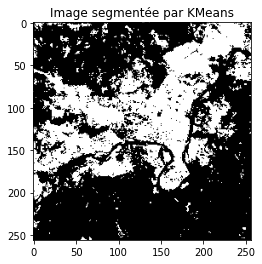

In [65]:
# Convertir l'image en un tableau 1D de pixels avec 1 caractéristique (l'intensité)
X2 = img2.reshape(-1, 1)

# Créer un objet KMeans avec le nombre de classes souhaité et les centres initiaux des classes
kmeans = KMeans(n_class, init='k-means++',n_init=10)

# Faire tourner l'algorithme sur le tableau X avec la méthode fit()
kmeans.fit(X2)

# Obtenir les classes de chaque pixel avec la méthode predict()
labels2 = kmeans.predict(X2)

# Convertir les labels en une image segmentée avec la même forme que l'image originale
segmented_img2 = labels2.reshape(img2.shape)

# Afficher l'image segmentée avec matplotlib
plt.imshow(segmented_img2, cmap='gray')
plt.title('Image segmentée par KMeans')
plt.show()

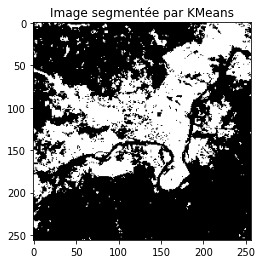

In [66]:

X3 = img3.reshape(-1, 1)


kmeans = KMeans(n_class, init='k-means++',n_init=10)


kmeans.fit(X3)


labels3 = kmeans.predict(X3)


segmented_img3 = labels3.reshape(img3.shape)


plt.imshow(segmented_img3, cmap='gray')
plt.title('Image segmentée par KMeans')
plt.show()

Faites de même avec les deux autres images. Avec quels canaux pouvez vous obtenir les meilleures segmentation ? Jusqu'à combien de classes ? 

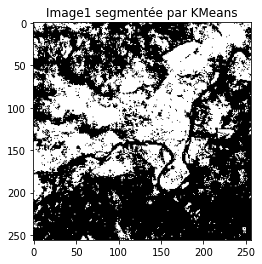

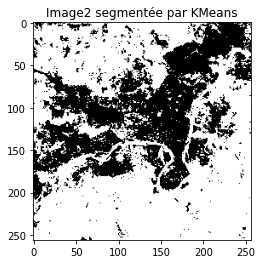

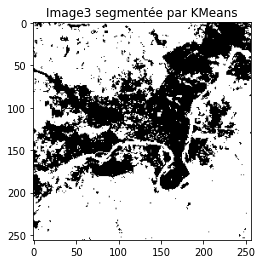

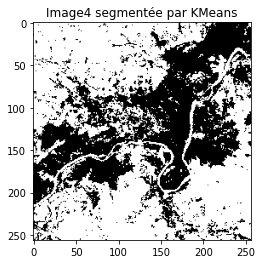

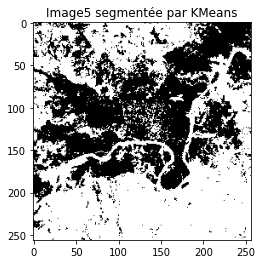

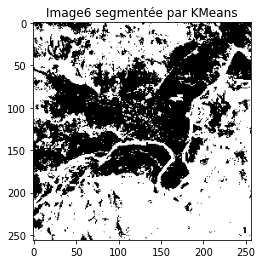

In [67]:
path_img = 'Landstat_Kedougou/landsatkedougouC' 
n_bands = 6 
size = 256
n_class = 2

img1 = load_image(path_img +'1')
img2 = load_image(path_img +'2')
img3 = load_image(path_img +'3')
img4 = load_image(path_img +'4')
img5 = load_image(path_img +'5')
img6 = load_image(path_img +'6')

X1 = img1.reshape(-1, 1)
X2 = img2.reshape(-1, 1)
X3 = img3.reshape(-1, 1)
X4 = img4.reshape(-1, 1)
X5 = img5.reshape(-1, 1)
X6 = img6.reshape(-1, 1)

kmeans1 = KMeans(n_class, init='k-means++',n_init=10)
kmeans2 = KMeans(n_class, init='k-means++',n_init=10)
kmeans3 = KMeans(n_class, init='k-means++',n_init=10)
kmeans4 = KMeans(n_class, init='k-means++',n_init=10)
kmeans5 = KMeans(n_class, init='k-means++',n_init=10)
kmeans6 = KMeans(n_class, init='k-means++',n_init=10)

# Faire tourner l'algorithme sur le tableau X avec la méthode fit()
kmeans1.fit(X1)
kmeans2.fit(X2)
kmeans3.fit(X3)
kmeans4.fit(X4)
kmeans5.fit(X5)
kmeans6.fit(X6)

# Obtenir les classes de chaque pixel avec la méthode predict()
labels1 = kmeans1.predict(X1)
labels2 = kmeans2.predict(X2)
labels3 = kmeans3.predict(X3)
labels4 = kmeans4.predict(X4)
labels5 = kmeans5.predict(X5)
labels6 = kmeans6.predict(X6)

# Convertir les labels en une image segmentée avec la même forme que l'image originale
segmented_img1 = labels1.reshape(img1.shape)
segmented_img2 = labels2.reshape(img1.shape)
segmented_img3 = labels3.reshape(img1.shape)
segmented_img4 = labels4.reshape(img1.shape)
segmented_img5 = labels5.reshape(img1.shape)
segmented_img6 = labels6.reshape(img1.shape)

# Afficher l'image segmentée avec matplotlib
plt.imshow(segmented_img1, cmap='gray')
plt.title('Image1 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img2, cmap='gray')
plt.title('Image2 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img3, cmap='gray')
plt.title('Image3 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img4, cmap='gray')
plt.title('Image4 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img5, cmap='gray')
plt.title('Image5 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img6, cmap='gray')
plt.title('Image6 segmentée par KMeans')
plt.show()


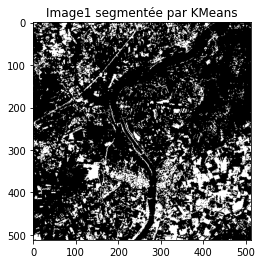

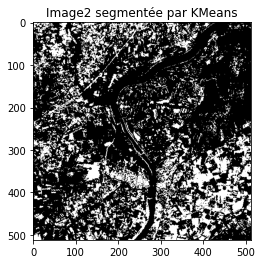

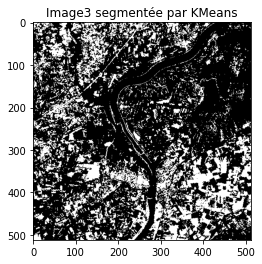

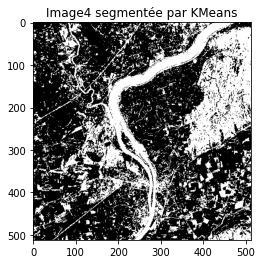

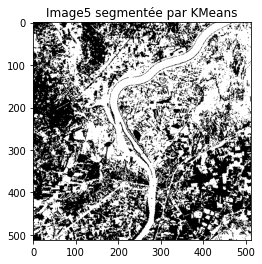

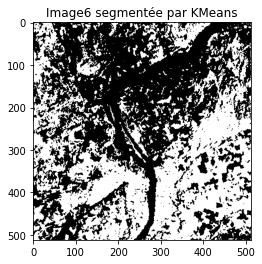

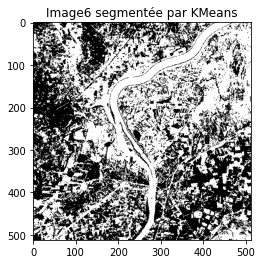

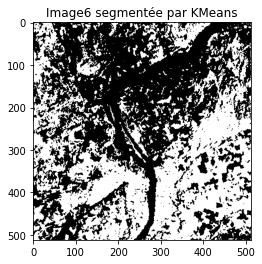

In [68]:
path_img = 'Landstat_Tarascon/landsattarasconC' 
n_bands = 8 
size = 512
n_class = 2

img1 = load_image(path_img +'1')
img2 = load_image(path_img +'2')
img3 = load_image(path_img +'3')
img4 = load_image(path_img +'4')
img5 = load_image(path_img +'5')
img6 = load_image(path_img +'6')
img7 = load_image(path_img +'7')
img8 = load_image(path_img +'8')

X1 = img1.reshape(-1, 1)
X2 = img2.reshape(-1, 1)
X3 = img3.reshape(-1, 1)
X4 = img4.reshape(-1, 1)
X5 = img5.reshape(-1, 1)
X6 = img6.reshape(-1, 1)
X7 = img7.reshape(-1, 1)
X8 = img8.reshape(-1, 1)

kmeans1 = KMeans(n_class, init='k-means++',n_init=10)
kmeans2 = KMeans(n_class, init='k-means++',n_init=10)
kmeans3 = KMeans(n_class, init='k-means++',n_init=10)
kmeans4 = KMeans(n_class, init='k-means++',n_init=10)
kmeans5 = KMeans(n_class, init='k-means++',n_init=10)
kmeans6 = KMeans(n_class, init='k-means++',n_init=10)
kmeans7 = KMeans(n_class, init='k-means++',n_init=10)
kmeans8 = KMeans(n_class, init='k-means++',n_init=10)

# Faire tourner l'algorithme sur le tableau X avec la méthode fit()
kmeans1.fit(X1)
kmeans2.fit(X2)
kmeans3.fit(X3)
kmeans4.fit(X4)
kmeans5.fit(X5)
kmeans6.fit(X6)
kmeans7.fit(X7)
kmeans8.fit(X8)
# Obtenir les classes de chaque pixel avec la méthode predict()
labels1 = kmeans1.predict(X1)
labels2 = kmeans2.predict(X2)
labels3 = kmeans3.predict(X3)
labels4 = kmeans4.predict(X4)
labels5 = kmeans5.predict(X5)
labels6 = kmeans6.predict(X6)
labels7 = kmeans5.predict(X7)
labels8 = kmeans6.predict(X8)
# Convertir les labels en une image segmentée avec la même forme que l'image originale
segmented_img1 = labels1.reshape(img1.shape)
segmented_img2 = labels2.reshape(img1.shape)
segmented_img3 = labels3.reshape(img1.shape)
segmented_img4 = labels4.reshape(img1.shape)
segmented_img5 = labels5.reshape(img1.shape)
segmented_img6 = labels6.reshape(img1.shape)
segmented_img7 = labels5.reshape(img1.shape)
segmented_img8 = labels6.reshape(img1.shape)
# Afficher l'image segmentée avec matplotlib
plt.imshow(segmented_img1, cmap='gray')
plt.title('Image1 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img2, cmap='gray')
plt.title('Image2 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img3, cmap='gray')
plt.title('Image3 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img4, cmap='gray')
plt.title('Image4 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img5, cmap='gray')
plt.title('Image5 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img6, cmap='gray')
plt.title('Image6 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img7, cmap='gray')
plt.title('Image6 segmentée par KMeans')
plt.show()

plt.imshow(segmented_img8, cmap='gray')
plt.title('Image6 segmentée par KMeans')
plt.show()